In [18]:
# Import libraries!
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

## Model

In [39]:
# Helper for time-regulated production
def pulse_input(t, t_on, t_off, rate):
    if t_on <= t <= t_off:
        return rate
    else:
        return 0.0

# ODE model (dynamic L and R2)
def model(states, t,
          L_on, L_off, L_rate,
          R2_on, R2_off, R2_rate,
          k_a, k_b,       # R1 + L <-> R1L
          k_c, k_d,       # pr_a + R1 <-> pr_R1
          k_e, k_f,       # pr_a + R2 <-> pr_R2
          k_deg1,         # G degradation
          k_deg2,         # R2 degradation
          k_deg3,         # R1 and R1L degradation
          k_syn):         # G synthesis from pr_a
    """
    states = [R1, pr_a, pr_R1, pr_R2, R1L, G, L, R2]
    """

    R1, pr_a, pr_R1, pr_R2, R1L, G, L, R2 = states

    # Time-regulated production rates
    u_L  = pulse_input(t,  L_on,  L_off,  L_rate)
    u_R2 = pulse_input(t, R2_on, R2_off, R2_rate)

    # R1 dynamics: binds L, binds promoter, degrades
    R1_prime = (
        - k_a * R1 * L      # bind L -> R1L
        + k_b * R1L         # unbind L
        + k_deg3 * R1L       # degrade R1L to free R1
        - k_c * pr_a * R1   # bind promoter
        + k_d * pr_R1       # unbind promoter
    )

    # R1L complex dynamics
    R1L_prime = (
        + k_a * R1 * L      # form complex
        - k_b * R1L         # dissociate
        - k_deg3 * R1L      # degrade complex
    )

    # Ligand L dynamics
    L_prime = (
        + u_L               # time-regulated production
        - k_a * R1 * L      # bind R1
        + k_b * R1L         # unbind
        - k_deg3 * L        # degrade free L
        - k_deg3 * R1L      # degrade bound L
    )

    # Promoter states
    pr_a_prime = (
        - k_c * pr_a * R1   # bind R1
        + k_d * pr_R1       # unbind R1
        - k_e * pr_a * R2   # bind R2
        + k_f * pr_R2       # unbind R2
    )

    pr_R1_prime = (
        + k_c * pr_a * R1   # bind
        - k_d * pr_R1       # unbind
    )

    pr_R2_prime = (
        + k_e * pr_a * R2   # bind
        - k_f * pr_R2       # unbind
    )

    # R2 dynamics (real species now)
    R2_prime = (
        + u_R2              # time-regulated production
        - k_e * pr_a * R2   # bind promoter
        + k_f * pr_R2       # unbind promoter
        - k_deg2 * R2       # degrade free R2
    )

    # Gene product G
    G_prime = k_syn * pr_a - k_deg1 * G

    return [R1_prime, pr_a_prime, pr_R1_prime, pr_R2_prime,
            R1L_prime, G_prime, L_prime, R2_prime]


## Figure 2 — Time Series

In [46]:
# ---------- initial conditions ----------
R1_0    = 5.0
pr_a_0  = 0.1   # active promoter
pr_R1_0 = 0.0
pr_R2_0 = 0.0
R1L_0   = 0.0
G_0     = 0.0
L_0     = 0.0
R2_0    = 0.0

states0 = [R1_0, pr_a_0, pr_R1_0, pr_R2_0, R1L_0, G_0, L_0, R2_0]

# ---------- parameters ----------
k_a = 0.05
k_b = 0.10
k_c = 0.70
k_d = 0.30
k_e = 0.50
k_f = 0.30
k_deg1 = 0.02   # G degradation
k_deg2 = 0.05   # R2 degradation
k_deg3 = 0.02   # R1 / R1L / L degradation
k_syn  = 0.50   # G synthesis from pr_a

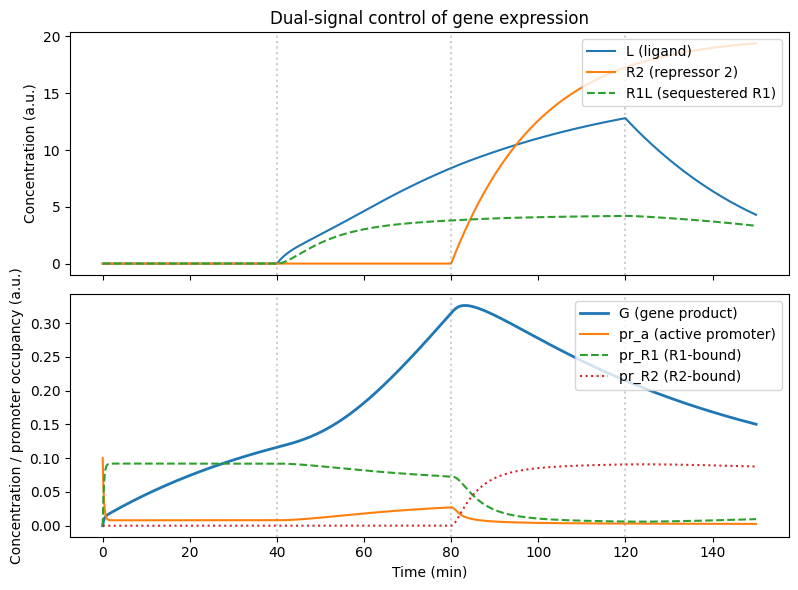

In [47]:
# =========================
# Figure 2: Time-resolved response to sequential ligand and repressor pulses
# =========================

# ---------- input pulses for 4 phases ----------
# Phase 1:  0–40   L OFF, R2 OFF
# Phase 2: 40–80   L ON,  R2 OFF
# Phase 3: 80–120  L ON,  R2 ON
# Phase 4: 120–150 L OFF, R2 ON

L_on_time   = 40.0
L_off_time  = 120.0
L_prod_rate = 0.5

R2_on_time   = 80.0
R2_off_time  = 150.0
R2_prod_rate = 1.0

# time grid
t_final = np.linspace(0, 150, 1001)

# ---------- simulate ----------
solution = odeint(
    model, states0, t_final,
    args=(L_on_time, L_off_time, L_prod_rate,
          R2_on_time, R2_off_time, R2_prod_rate,
          k_a, k_b,
          k_c, k_d,
          k_e, k_f,
          k_deg1, k_deg2, k_deg3,
          k_syn)
)

# unpack solution
R1    = solution[:, 0]
pr_a  = solution[:, 1]
pr_R1 = solution[:, 2]
pr_R2 = solution[:, 3]
R1L   = solution[:, 4]
G     = solution[:, 5]
L     = solution[:, 6]
R2    = solution[:, 7]

# ---------- Figure 2: stacked time-series ----------
fig, (ax_top, ax_bottom) = plt.subplots(
    2, 1, sharex=True, figsize=(8, 6)
)

# ---- top panel: inputs / upstream species ----
ax_top.plot(t_final, L,  label="L (ligand)")
ax_top.plot(t_final, R2, label="R2 (repressor 2)")
ax_top.plot(t_final, R1L, linestyle="--", label="R1L (sequestered R1)")

ax_top.set_ylabel("Concentration (a.u.)")
ax_top.set_title("Dual-signal control of gene expression")
ax_top.legend(loc="upper right")

# ---- bottom panel: promoter states + output ----
ax_bottom.plot(t_final, G,    linewidth=2, label="G (gene product)")
ax_bottom.plot(t_final, pr_a,           label="pr_a (active promoter)")
ax_bottom.plot(t_final, pr_R1, linestyle="--", label="pr_R1 (R1-bound)")
ax_bottom.plot(t_final, pr_R2, linestyle=":",  label="pr_R2 (R2-bound)")

ax_bottom.set_xlabel("Time (min)")
ax_bottom.set_ylabel("Concentration / promoter occupancy (a.u.)")
ax_bottom.legend(loc="upper right")

# optional: vertical lines to mark phase transitions
for ax in (ax_top, ax_bottom):
    for x in [40, 80, 120]:
        ax.axvline(x, color="gray", linestyle=":", alpha=0.4)

plt.tight_layout()
plt.show()


In [48]:
# Helper: check for steady state in ODE solution
def check_steady_state(t, sol,
                       species_indices=None,
                       window=100,
                       rel_tol=5e-3,
                       abs_tol=1e-4):
    
    T = sol.shape[0]

    if species_indices is None:
        species_indices = [5]  # default: G in your model

    # need at least 2 windows to compare
    if T < 2 * window:
        raise ValueError(
            f"Not enough time points ({T}) for two windows of size {window}."
        )

    steady_values = {}
    all_ok = True

    # indices for the two windows
    last_win = np.arange(T - window, T)
    prev_win = np.arange(T - 2 * window, T - window)

    for idx in species_indices:
        y = sol[:, idx]
        y_last = y[last_win]
        y_prev = y[prev_win]

        mean_last = y_last.mean()
        mean_prev = y_prev.mean()

        diff = np.abs(mean_last - mean_prev)
        scale = max(np.max(np.abs([mean_last, mean_prev])), 1.0)

        rel_change = diff / scale

        # store the "steady" estimate as the mean of the last window
        steady_values[idx] = mean_last

        if not (diff < abs_tol or rel_change < rel_tol):
            all_ok = False

    return all_ok, steady_values


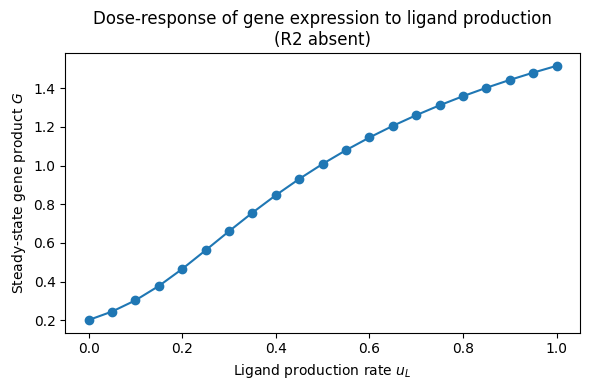

In [44]:
# =========================
# Figure 3: Dose-response of G to ligand production rate
# =========================

# helper: run model for a given L production rate with R2 absent
def run_model_L_rate(L_rate,
                     t_end=400, n_points=1201):
    """
    Simulate the system with a constant ligand production rate L_rate
    and no R2 present.
    """
    t = np.linspace(0, t_end, n_points)

    # R2 is absent: no production
    R2_on_time  = 0.0
    R2_off_time = 0.0
    R2_prod_rate = 0.0

    # L is produced the entire simulation at rate L_rate
    L_on_time  = 0.0
    L_off_time = t_end
    L_prod_rate = L_rate

    sol = odeint(
        model, states0, t,
        args=(L_on_time, L_off_time, L_prod_rate,
              R2_on_time, R2_off_time, R2_prod_rate,
              k_a, k_b,
              k_c, k_d,
              k_e, k_f,
              k_deg1, k_deg2, k_deg3,
              k_syn)
    )
    return t, sol

# sweep over ligand production rates
L_rates = np.linspace(0.0, 1.0, 21)   # adjust max if you want a wider range
G_ss = []

# for L_rate in L_rates:
#     t, sol = run_model_L_rate(L_rate)
#     G_trace = sol[:, 5]  # column 5 is G
#     # use mean of last 50 time points as "steady-state" G
#     G_ss.append(G_trace[-50:].mean())

for L_rate in L_rates:
    t, sol = run_model_L_rate(L_rate)
    converged, steady_vals = check_steady_state(t, sol,
                                                species_indices=[5],  # G only
                                                window=50,
                                                rel_tol=1e-3,
                                                abs_tol=1e-5)
    if not converged:
        print(f"Warning: simulation may not have reached steady state for u_L={L_rate:.3f}")

    G_ss.append(steady_vals[5])  # index 5 = G

# make dose-response plot
plt.figure(figsize=(6, 4))
plt.plot(L_rates, G_ss, marker="o")
plt.xlabel("Ligand production rate $u_L$")
plt.ylabel("Steady-state gene product $G$")
plt.title("Dose-response of gene expression to ligand production\n(R2 absent)")
plt.tight_layout()
plt.show()


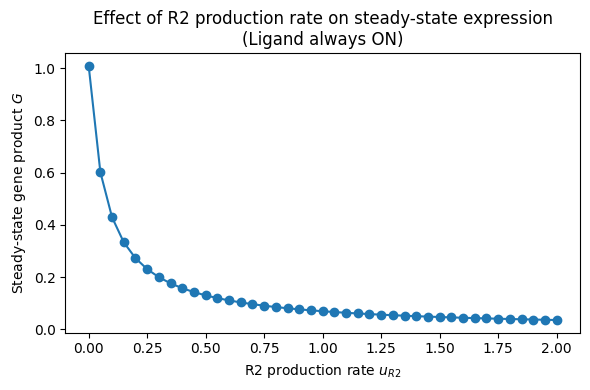

In [49]:
# =========================
# Figure 4A: Sweep R2 production rate
# =========================

def run_model_R2_rate(R2_rate,
                      t_end=400, n_points=1201):
    """
    Run model where ligand is ON continuously and R2 is produced at rate R2_rate.
    """
    t = np.linspace(0, t_end, n_points)

    # ligand always on at strong level so that R1 remains sequestered
    L_on_time   = 0.0
    L_off_time  = t_end
    L_prod_rate = 0.5  # fixed sufficiently high for activation

    # R2 produced continuously at chosen rate
    R2_on_time   = 0.0
    R2_off_time  = t_end
    R2_prod_rate = R2_rate

    sol = odeint(
        model, states0, t,
        args=(L_on_time, L_off_time, L_prod_rate,
              R2_on_time, R2_off_time, R2_prod_rate,
              k_a, k_b,
              k_c, k_d,
              k_e, k_f,
              k_deg1, k_deg2, k_deg3,
              k_syn)
    )
    return t, sol


R2_rates = np.linspace(0, 2.0, 41)  # from no R2 to strong repression
G_ss_R2 = []

for R2_rate in R2_rates:
    t, sol = run_model_R2_rate(R2_rate)
    converged, steady_vals = check_steady_state(
        t, sol,
        species_indices=[5],  # G
        window=100,
        rel_tol=5e-3,
        abs_tol=1e-4
    )
    if not converged:
        print(f"Warning: may not be steady state for R2_rate={R2_rate:.2f}")
    G_ss_R2.append(steady_vals[5])


# Plot
plt.figure(figsize=(6, 4))
plt.plot(R2_rates, G_ss_R2, marker="o")
plt.xlabel("R2 production rate $u_{R2}$")
plt.ylabel("Steady-state gene product $G$")
plt.title("Effect of R2 production rate on steady-state expression\n(Ligand always ON)")
plt.tight_layout()
plt.show()


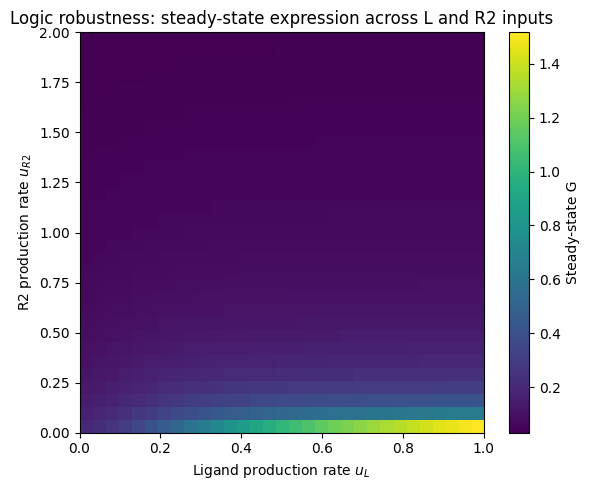

In [50]:
# ================================
# Extra Figure: Logic robustness heatmap (L_rate vs R2_rate)
# ================================

def run_model_L_R2(L_rate, R2_rate,
                   t_end=400, n_points=1201):
    """
    Simulate the system with constant ligand and R2 production
    at specified rates L_rate and R2_rate.
    """
    t = np.linspace(0, t_end, n_points)

    # ligand always on
    L_on_time   = 0.0
    L_off_time  = t_end
    L_prod_rate = L_rate

    # R2 always on
    R2_on_time   = 0.0
    R2_off_time  = t_end
    R2_prod_rate = R2_rate

    sol = odeint(
        model, states0, t,
        args=(L_on_time, L_off_time, L_prod_rate,
              R2_on_time, R2_off_time, R2_prod_rate,
              k_a, k_b,
              k_c, k_d,
              k_e, k_f,
              k_deg1, k_deg2, k_deg3,
              k_syn)
    )
    return t, sol


# define grid of ligand and R2 rates
L_values  = np.linspace(0.0, 1.0, 31)   # x-axis
R2_values = np.linspace(0.0, 2.0, 31)   # y-axis

G_ss_grid = np.zeros((len(R2_values), len(L_values)))  # rows=y, cols=x

for i, R2_rate in enumerate(R2_values):
    for j, L_rate in enumerate(L_values):
        t, sol = run_model_L_R2(L_rate, R2_rate)
        converged, steady_vals = check_steady_state(
            t, sol,
            species_indices=[5],  # G only
            window=100,
            rel_tol=5e-3,
            abs_tol=1e-4
        )
        if not converged:
            print(f"Warning: may not be steady state for u_L={L_rate:.2f}, u_R2={R2_rate:.2f}")
        G_ss_grid[i, j] = steady_vals[5]


# --- plot heatmap ---
plt.figure(figsize=(6, 5))

# imshow expects [rows, cols] = [R2, L]
im = plt.imshow(
    G_ss_grid,
    origin="lower",
    aspect="auto",
    extent=[L_values[0], L_values[-1], R2_values[0], R2_values[-1]]
)

plt.colorbar(im, label="Steady-state G")

plt.xlabel("Ligand production rate $u_L$")
plt.ylabel("R2 production rate $u_{R2}$")
plt.title("Logic robustness: steady-state expression across L and R2 inputs")

plt.tight_layout()
plt.show()


Baseline steady-state G = 0.2727266095810119
k_a: sensitivity S_p = 0.133
k_b: sensitivity S_p = -0.111
k_c: sensitivity S_p = -0.163
k_d: sensitivity S_p = 0.164
k_e: sensitivity S_p = -0.732
k_f: sensitivity S_p = 0.728
k_deg1: sensitivity S_p = -1.005
k_deg2: sensitivity S_p = 0.728
k_deg3: sensitivity S_p = -0.223


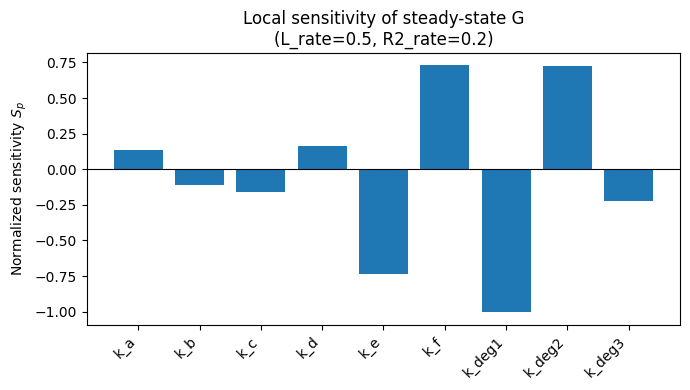

In [51]:
# ============================================
# Local sensitivity analysis of model parameters
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Helper: simulate with arbitrary parameter set and fixed inputs
def run_model_for_sensitivity(L_rate, R2_rate, params,
                              t_end=400, n_points=1201):
    """
    Simulate the model for given ligand and R2 production rates,
    using a supplied dictionary of kinetic parameters.
    """
    t = np.linspace(0, t_end, n_points)

    # ligand and R2 both ON continuously
    L_on_time   = 0.0
    L_off_time  = t_end
    R2_on_time  = 0.0
    R2_off_time = t_end

    sol = odeint(
        model, states0, t,
        args=(L_on_time, L_off_time, L_rate,
              R2_on_time, R2_off_time, R2_rate,
              params["k_a"], params["k_b"],
              params["k_c"], params["k_d"],
              params["k_e"], params["k_f"],
              params["k_deg1"], params["k_deg2"], params["k_deg3"],
              params["k_syn"])
    )
    return t, sol


def steady_state_G_from_params(L_rate, R2_rate, params):
    """
    Convenience wrapper: run model and return steady-state G
    using the existing check_steady_state utility.
    """
    t, sol = run_model_for_sensitivity(L_rate, R2_rate, params)
    converged, steady_vals = check_steady_state(
        t, sol,
        species_indices=[5]  # G only
        # uses default window, rel_tol, abs_tol
    )
    if not converged:
        print("Warning: simulation may not have reached steady state.")
    return steady_vals[5]


# -----------------------------
# Baseline parameters & inputs
# -----------------------------

# store current global parameters in a dict
base_params = {
    "k_a": k_a,
    "k_b": k_b,
    "k_c": k_c,
    "k_d": k_d,
    "k_e": k_e,
    "k_f": k_f,
    "k_deg1": k_deg1,
    "k_deg2": k_deg2,
    "k_deg3": k_deg3,
    "k_syn":  k_syn,
}

# choose an input regime where G is intermediate
# (not fully ON and not fully OFF)
L_rate_base  = 0.5   # ligand production
R2_rate_base = 0.2   # moderate R2 production

G_ss_base = steady_state_G_from_params(L_rate_base, R2_rate_base, base_params)
print("Baseline steady-state G =", G_ss_base)

# -----------------------------
# Local sensitivity calculation
# -----------------------------

delta = 0.10  # 10% perturbation

# parameters we want to test (binding + degradation)
params_to_test = [
    "k_a", "k_b",   # L–R1 binding/unbinding
    "k_c", "k_d",   # R1–promoter binding/unbinding
    "k_e", "k_f",   # R2–promoter binding/unbinding
    "k_deg1",       # G degradation
    "k_deg2",       # R2 degradation
    "k_deg3",       # R1/R1L/L degradation
]

sensitivities = []

for name in params_to_test:
    p0 = base_params[name]

    # +10% and -10% perturbations
    params_plus  = base_params.copy()
    params_minus = base_params.copy()
    params_plus[name]  = p0 * (1.0 + delta)
    params_minus[name] = p0 * (1.0 - delta)

    G_plus  = steady_state_G_from_params(L_rate_base, R2_rate_base, params_plus)
    G_minus = steady_state_G_from_params(L_rate_base, R2_rate_base, params_minus)

    # central finite-difference, normalized sensitivity:
    # S_p = (ΔG / G) / (Δp / p)
    dG = G_plus - G_minus
    dG_norm = dG / (2.0 * G_ss_base)     # relative change in G
    dp_norm = delta                      # relative change in p (±10%)
    S_p = dG_norm / dp_norm

    sensitivities.append(S_p)
    print(f"{name}: sensitivity S_p = {S_p:.3f}")

sensitivities = np.array(sensitivities)

# -----------------------------
# Plot sensitivity bar chart
# -----------------------------

plt.figure(figsize=(7, 4))
x = np.arange(len(params_to_test))

plt.bar(x, sensitivities)
plt.axhline(0, color="black", linewidth=0.8)
plt.xticks(x, params_to_test, rotation=45, ha="right")
plt.ylabel("Normalized sensitivity $S_p$")
plt.title("Local sensitivity of steady-state G\n"
          f"(L_rate={L_rate_base}, R2_rate={R2_rate_base})")

plt.tight_layout()
plt.show()
